In [4]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

In [5]:
from model_class.model_simply_traffic_lights import TrafficSimulation as sim

In [8]:
# Effect of density on flow rate for varying number of timesteps

# first def the function to be run in the multiprocessing (only one input argument (easier)), 
# ideally only one output as well 

def number_steps_sim( number_of_steps): 
    # def paras 
    densities = np.linspace(0, 1, 100)
    road_length = 70
    car_slow_down_prob = 0.1
    road_speed_limit = 9

    # 
    road_speed_limit_list = [road_speed_limit]*road_length
    traffic_light_list = []
    
    #
    flow_rates = np.zeros_like(densities) 
    
    for index,density in enumerate(densities): 
        ts = sim(road_speed_limit_list, traffic_light_list, density, car_slow_down_prob)

        for _ in range(number_of_steps): 
            ts.update() 
        
        flow_rate = ts.data_laps/number_of_steps
        flow_rates[index] = flow_rate

    return flow_rates 


In [57]:
num_cpu = mp.cpu_count() # get how many cpus on system 
pool = mp.Pool(processes=num_cpu)

## warning use a small number first, will take time for large values (20 is taken awhile on my system)
number_of_repeats = 5 # number of iteration for reruns, to compute mean and var, 

data_points  = 100 # np.linspace(0,1,100)
nts = [10, 50, 75, 100]#  1000, 10000]

# allocate mem, based on the number of data point and number of repeats.
flow_rates_by_steps = [np.zeros((number_of_repeats, data_points))]*len(nts) 

for i,n in enumerate( nts): 
    # run multiprocessing
    result = pool.map(number_steps_sim, [n]*number_of_repeats) 
    # reshape to np.array
    flow_rates_by_steps[i] = np.array(result).reshape((number_of_repeats, data_points))


In [58]:
def calculate_mean_var(results_data):
    # allocate mem for speed.
    mean_values = [None]*len(results_data)
    var_values  = [None]*len(results_data) 
    # compute the mean and var for each batch.
    for i,data in enumerate(results_data):
        mean_values[i] = np.mean(data, axis=0)
        var_values[i] =np.var(data, axis=0) 
    return mean_values, var_values

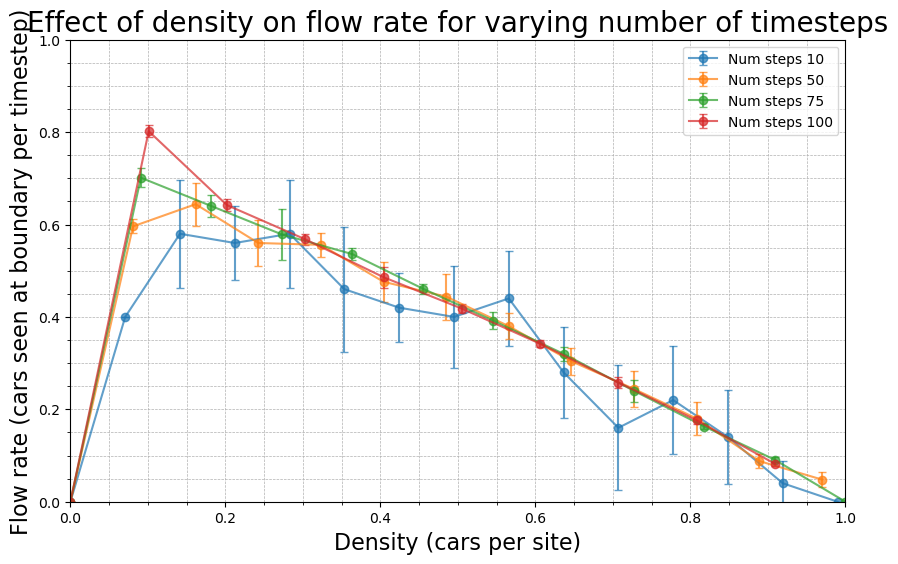

In [59]:
means,vars = calculate_mean_var(flow_rates_by_steps)
# Plot line plot with error bars representing variance
plt.figure(figsize=(10, 6))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
for i, mean in enumerate(means):
    offset = 7+ (i) # so the graph does not look overcrowed, [::offset] at the end of array
    plt.errorbar( np.linspace(0, 1, 100)[::offset], mean[::offset], yerr=np.sqrt( vars[i] )[::offset] , alpha=0.7, fmt='-o', label=f'Num steps {nts[i]}',capsize=3)
plt.xlabel(f'Density (cars per site)', size=16)
plt.ylabel('Flow rate (cars seen at boundary per timestep)', size=16)
plt.title('Effect of density on flow rate for varying number of timesteps',size=20)
plt.legend(fontsize='medium',loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()